In [1]:
!pip install spacy
!python -m spacy download es_core_news_sm
import spacy
import pandas as pd
import re
import string
import unicodedata
import numpy as np

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 66.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


Tras importar todas las librerías necesarias, cargo la base de datos y cambio el nombre a las columnas para que más tarde sea más sencillo preprocesarlas.

In [2]:
df = pd.read_excel('muestra.xlsx')
df.rename(columns={'Nombre': 'Nombre empresa', 'Código primario NACE Rev. 2': 'Código primario', 'Código(s) segundario(s) NACE Rev. 2':'Códigos secundarios', 'Unnamed: 0':'Índice'}, inplace=True)

In [3]:
# Función para añadir un cero delante si el número tiene tres cifras
def añadir_cero(num):
    if pd.isna(num):
        return num
    num_int = int(num)  # Convertimos el número a entero
    if 100 <= num_int <= 999:  # Verificamos si el número tiene tres cifras
        return f'0{num_int}'  # Añadimos un cero delante y devolvemos como string
    else:
        return str(num_int)  # Devolvemos el número como string sin cambios

# Aplicamos la función a la columna 'Datos'
df['Código primario'] = df['Código primario'].apply(añadir_cero)
#df['Códigos secundarios'] = df['Códigos secundarios'].apply(añadir_cero)

In [4]:
df.head()

,Índice,Nombre empresa,Número BvD,Código primario,Códigos secundarios,Descripción actividad
0,1.0,KL GRUT 78 SLU,ESB57648966,4332,NaN,"a). Fabricacion, compraventa al detall y mayor..."
1,2.0,GENERAL DE ENCOFRADOS Y CIMENTACIONES SL,ESB10394724,4120,NaN,"LA CREACION, ADQUISICION, REFORMA, EXPLOTACION..."
2,3.0,ELECTRO OSMA 2018 SOCIEDAD LIMITADA.,ESB02606168,4321,NaN,La realización de instalaciones eléctricas en ...
3,4.0,CHANRIL TRADE SL,ESB82716226,6820,NaN,VENTA AL POR MAYOR DE TODO TIPO DE ARTICULOS D...
4,5.0,LA POSADA DEL MAR SL,ESB53552972,5510,NaN,Explotación de un hotel de cuatro estrellas.


A continuación, he definido una función para combinar las filas que pertenecen a la misma empresa pero cuentan con más de un código secundario. De esta forma consigo que la columna 'Códigos Secundarios' contenga todos los códigos secundarios separados por comas.

In [5]:
def combinar_filas(row, cod_secundario):
    if pd.isna(row['Nombre empresa']) and cod_secundario is not None:
        return f"{cod_secundario}, {row['Códigos secundarios']}"
    else:
        return row['Códigos secundarios']

# Itero sobre el DataFrame en reversa para evitar cambiar índices que aún no he procesado
for index in range(len(df) - 1, 0, -1):
    if pd.isna(df.loc[index, 'Nombre empresa']):
        # Combino los códigos secundarios
        df.loc[index - 1, 'Códigos secundarios'] = combinar_filas(
            df.loc[index], df.loc[index - 1, 'Códigos secundarios']
        )
        # Elimino la fila actual ya que su contenido se ha fusionado con la fila anterior
        df.drop(index, inplace=True)

# Reinicio el índice después de eliminar filas
df.reset_index(drop=True, inplace=True)

# Defino una función para formatear correctamente los códigos secundarios
def format_cod_secundarios(code):
    if pd.isna(code) or code == '':
        return ''
    # Divido los códigos por la coma, convierto cada uno a entero y los uno nuevamente con comas
    return ', '.join(str(int(float(c))) for c in str(code).split(', '))

# Aplico la función a la columna 'Códigos secundarios'
df['Códigos secundarios'] = df['Códigos secundarios'].apply(format_cod_secundarios)

# Elimino aquellas filas que no contienen datos en las columnas 'Descripción actividad', 'Nombre empresa' o 'Código primario'
df['Descripción actividad'].replace('', np.nan, inplace=True)
df['Nombre empresa'].replace('', np.nan, inplace=True)
df['Código primario'].replace('', np.nan, inplace=True)
df.dropna(subset=['Descripción actividad'], inplace=True)
df.dropna(subset=['Nombre empresa'], inplace=True)
df.dropna(subset=['Código primario'], inplace=True)

In [6]:
df.head()

,Índice,Nombre empresa,Número BvD,Código primario,Códigos secundarios,Descripción actividad
0,1.0,KL GRUT 78 SLU,ESB57648966,4332,,"a). Fabricacion, compraventa al detall y mayor..."
1,2.0,GENERAL DE ENCOFRADOS Y CIMENTACIONES SL,ESB10394724,4120,,"LA CREACION, ADQUISICION, REFORMA, EXPLOTACION..."
2,3.0,ELECTRO OSMA 2018 SOCIEDAD LIMITADA.,ESB02606168,4321,,La realización de instalaciones eléctricas en ...
3,4.0,CHANRIL TRADE SL,ESB82716226,6820,,VENTA AL POR MAYOR DE TODO TIPO DE ARTICULOS D...
4,5.0,LA POSADA DEL MAR SL,ESB53552972,5510,,Explotación de un hotel de cuatro estrellas.


A continuación, se preprocesa la columna 'descripción de actividad'

In [7]:
# En primer lugar, cargo el modelo de lenguaje español 'es_core_news_sm'.
# Se desactivan el 'parser' (analizador sintáctico) y el 'ner' (reconocedor de entidades nombradas) para mejorar el rendimiento, dado que solo necesito la tokenización, lematización y eliminación de stopwords.
nlp = spacy.load('es_core_news_sm', disable=['parser', 'ner'])

# Esta función convierte cualquier carácter acentuado en su equivalente sin acento. Utiliza la forma de normalización Unicode NFKD para descomponer los caracteres en sus componentes,
# y luego une los que no son marcas de combinación (es decir, elimina los acentos).
def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    return "".join([c for c in nfkd_form if not unicodedata.combining(c)])

spanish_stop_words = ['a.', 'cnae', '-', '-c.n.a.e', 'a', 'acá', 'ahí', 'al', 'algo', 'algún', 'alguno', 'algunos', 'ante', 'antes', 'aquel', 'aquellas', 'aquellos', 'aquí', 'arriba', 'así', 'atras', 'aun', 'aunque', 'bajo', 'bastante', 'bien', 'cabe', 'cada', 'casi', 'cierto', 'ciertos', 'como', 'con', 'conmigo', 'contigo', 'contra', 'cual', 'cuales', 'cualquier', 'cualquiera', 'cuando', 'cuanto', 'cuantos', 'de', 'dejar', 'del', 'demás', 'demasiada', 'demasiadas', 'demasiado', 'demasiados', 'dentro', 'desde', 'donde', 'dos', 'el', 'él', 'ella', 'ellas', 'ellos', 'en', 'encima', 'entonces', 'entre', 'era', 'erais', 'éramos', 'eran', 'eras', 'eres', 'es', 'esa', 'esas', 'ese', 'eso', 'esos', 'esta', 'estaba', 'estabais', 'estábamos', 'estaban', 'estabas', 'estad', 'estada', 'estadas', 'estado', 'estados', 'estamos', 'están', 'estando', 'estar', 'estará', 'estarán', 'estarás', 'estaré', 'estaréis', 'estaremos', 'estaréis', 'estaremos', 'estará', 'estarán', 'estarás', 'estaré', 'estaría', 'estaríais', 'estaríamos', 'estarían', 'estarías', 'estas', 'este', 'esté', 'estéis', 'estemos', 'estén', 'estés', 'esto', 'estos', 'estoy', 'estuve', 'estuviera', 'estuvierais', 'estuviéramos', 'estuvieran', 'estuvieras', 'estuvieron', 'estuviese', 'estuvieseis', 'estuviésemos', 'estuviesen', 'estuvieses', 'estuvimos', 'estuviste', 'estuvisteis', 'estuviéramos', 'estuvieran', 'estuvieras', 'estuvieron', 'estuviese', 'estuvieseis', 'estuviésemos', 'estuviesen', 'estuvieses', 'estuvo', 'ex', 'excepto', 'fue', 'fuera', 'fuerais', 'fuéramos', 'fueran', 'fueras', 'fueron', 'fuese', 'fueseis', 'fuésemos', 'fuesen', 'fueses', 'fui', 'fuimos', 'fuiste', 'fuisteis', 'ha', 'habéis', 'había', 'habíais', 'habíamos', 'habían', 'habías', 'hace', 'haceis', 'hacemos', 'hacen', 'hacer', 'hacerlo', 'haces', 'hacia', 'hago', 'hasta', 'incluso', 'intenta', 'intentais', 'intentamos', 'intentan', 'intentar', 'intentas', 'intento', 'ir', 'jamás', 'junto', 'juntos', 'la', 'lo', 'las', 'los', 'largo', 'más', 'me', 'menos', 'mi', 'mía', 'mías', 'mientras', 'mío', 'míos', 'mis', 'misma', 'mismas', 'mismo', 'mismos', 'muy', 'nada', 'ni', 'ningún', 'ninguna', 'ningunas', 'ninguno', 'ningunos', 'no', 'nos', 'nosotras', 'nosotros', 'nuestra', 'nuestras', 'nuestro', 'nuestros', 'nunca', 'os', 'otra', 'otras', 'otro', 'otros', 'para', 'pero', 'poca', 'pocas', 'poco', 'pocos', 'podéis', 'podemos', 'poder', 'podrá', 'podrán', 'podría', 'podrían', 'podrías', 'por', 'porque', 'primero', 'puede', 'pueden', 'puedo', 'quien', 'quienes', 'qué', 'sabe', 'sabéis', 'sabemos', 'saben', 'saber', 'sabes', 'se', 'según', 'ser', 'si', 'sí', 'siendo', 'sin', 'sino', 'so', 'sobre', 'sois', 'solamente', 'solo', 'somos', 'soy', 'su', 'sus', 'suya', 'suyas', 'suyo', 'suyos', 'tal', 'tales', 'también', 'tampoco', 'tan', 'tanta', 'tantas', 'tanto', 'tantos', 'te', 'tenéis', 'tenemos', 'tener', 'tenga', 'tengáis', 'tengamos', 'tengan', 'tengas', 'tengo', 'ti', 'tiempo', 'tiene', 'tienen', 'toda', 'todas', 'todo', 'todos', 'tu', 'tus', 'tuve', 'tuviera', 'tuvierais', 'tuviéramos', 'tuvieran', 'tuvieras', 'tuvieron', 'tuviese', 'tuvieseis', 'tuviésemos', 'tuviesen', 'tuvieses', 'tuvimos', 'tuviste', 'tuvisteis', 'tuvo', 'tuya', 'tuyo', 'tuyos', 'un', 'una', 'unas', 'unos', 'uno', 'vosotras', 'vosotros', 'vuestra', 'vuestras', 'vuestro', 'vuestros', 'y', 'ya', 'yo', 'que', 'le', 'o', 'hay', 'durante', 'les', 'e', 'mí', 'mucho', 'muchos', 'algunas', 'tú', 'tuyas', 'estás', 'está', 'estáis']

# Función para limpiar y preprocesar el texto:

def preprocess_text_spacy(text):
    if pd.isnull(text) or not isinstance(text, str):
        return ""
    text = re.sub(r'\d', '', text)  # Utilizo una expresión regular para eliminar todos los dígitos del texto
    text = text.lower()
    doc = nlp(text)
    lemmas = []

    # Iterar sobre cada token en el objeto doc
    for token in doc:
        # Convertir el lema del token a minúsculas
        lemma_lower = token.lemma_.lower()

        # Comprobar si el lema no está en la lista de stopwords y si no es un signo de puntuación
        if lemma_lower not in spanish_stop_words and not token.is_punct:
            # Aplicar la función para remover acentos al lema
            lemma_no_accents = remove_accents(token.lemma_)
            # Agregar el lema procesado a la lista de lemas
            lemmas.append(lemma_no_accents)
    return " ".join(lemmas)


df['Descripción actividad preprocesada'] = df['Descripción actividad'].apply(preprocess_text_spacy)
df.drop('Descripción actividad', axis=1, inplace=True)

In [8]:
df.head()

,Índice,Nombre empresa,Número BvD,Código primario,Códigos secundarios,Descripción actividad preprocesada
0,1.0,KL GRUT 78 SLU,ESB57648966,4332,,fabricacion compraventar detall mayorista real...
1,2.0,GENERAL DE ENCOFRADOS Y CIMENTACIONES SL,ESB10394724,4120,,creacion adquisicion reforma explotacion cuent...
2,3.0,ELECTRO OSMA 2018 SOCIEDAD LIMITADA.,ESB02606168,4321,,realizacion instalacion electrico general mont...
3,4.0,CHANRIL TRADE SL,ESB82716226,6820,,venta mayor tipo articulo menaje hogar regalo
4,5.0,LA POSADA DEL MAR SL,ESB53552972,5510,,explotacion hotel cuatro estrella


En este apartado se asigna una letra a cada empresa en función de la Sección NACE a la que corresponde. Estas letras se asignan en función a las dos primeras cifras de su código NACE principal según la tabla que se muestra a continuación:

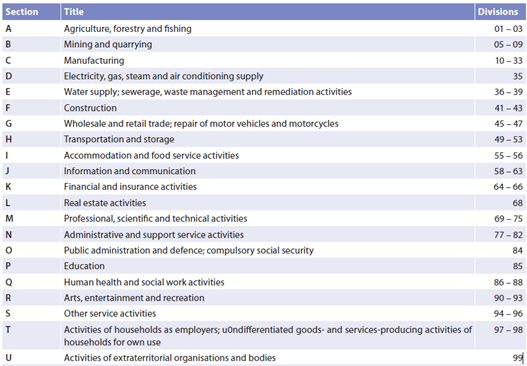

In [9]:
# Me quedo con los dos primeros dígitos de su código NACE
df['primeros_dos'] = df['Código primario'].str.slice(0, 2)

condiciones = [
    df['primeros_dos'].isin(['01', '02', '03']),
    df['primeros_dos'].isin(['05', '06', '07', '08', '09']),
    df['primeros_dos'].isin([f"{x:02d}" for x in range(10, 34)]),
    df['primeros_dos'].isin(['35']),
    df['primeros_dos'].isin(['36', '37', '38', '39']),
    df['primeros_dos'].isin(['41', '42', '43']),
    df['primeros_dos'].isin(['45', '46', '47']),
    df['primeros_dos'].isin(['49', '50', '51', '52', '53']),
    df['primeros_dos'].isin(['55', '56']),
    df['primeros_dos'].isin(['58', '59', '60', '61', '62','63']),
    df['primeros_dos'].isin(['64', '65', '66']),
    df['primeros_dos'].isin(['68']),
    df['primeros_dos'].isin(['69', '70', '71', '72', '73', '74', '75']),
    df['primeros_dos'].isin(['77', '78', '79', '80', '81', '82']),
    df['primeros_dos'].isin(['84']),
    df['primeros_dos'].isin(['85']),
    df['primeros_dos'].isin(['86', '87', '88']),
    df['primeros_dos'].isin(['90', '91', '92', '93']),
    df['primeros_dos'].isin(['94', '95', '96']),
    df['primeros_dos'].isin(['97', '98']),
    df['primeros_dos'].isin(['99'])
]

valores = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U']

# Asignar valores en 'sector' según las condiciones
df['sector'] = np.select(condiciones, valores, default=np.nan)

df = df.drop(columns=['primeros_dos'])

In [10]:
df.head()

,Índice,Nombre empresa,Número BvD,Código primario,Códigos secundarios,Descripción actividad preprocesada,sector
0,1.0,KL GRUT 78 SLU,ESB57648966,4332,,fabricacion compraventar detall mayorista real...,F
1,2.0,GENERAL DE ENCOFRADOS Y CIMENTACIONES SL,ESB10394724,4120,,creacion adquisicion reforma explotacion cuent...,F
2,3.0,ELECTRO OSMA 2018 SOCIEDAD LIMITADA.,ESB02606168,4321,,realizacion instalacion electrico general mont...,F
3,4.0,CHANRIL TRADE SL,ESB82716226,6820,,venta mayor tipo articulo menaje hogar regalo,L
4,5.0,LA POSADA DEL MAR SL,ESB53552972,5510,,explotacion hotel cuatro estrella,I


A continuación añado a la base de datos las columnas 'división, 'grupo' y 'clase' siguiendo los criterios de asignación de la NACE  a través del código primario.

In [11]:
# Función para extraer división, grupo y clase
def parse_nace_code(code):
    division = code[:2]
    group = code[:3]
    classe = code if len(code) > 2 else None  # Verificar si el código tiene la longitud adecuada
    return division, group, classe

# Aplicar la función al DataFrame
df[['división', 'grupo', 'clase']] = df['Código primario'].apply(lambda x: pd.Series(parse_nace_code(x)))


Elimino aquellas filas cuya Descripción de actividad esté vacía

In [12]:
df['longitud_descripcion'] = df['Descripción actividad preprocesada'].apply(lambda x: len(str(x).split()))
df = df[df['longitud_descripcion'] != 0]
df = df.drop(columns=['longitud_descripcion'])

In [13]:
df.head()

,Índice,Nombre empresa,Número BvD,Código primario,Códigos secundarios,Descripción actividad preprocesada,sector,división,grupo,clase
0,1.0,KL GRUT 78 SLU,ESB57648966,4332,,fabricacion compraventar detall mayorista real...,F,43,433,4332
1,2.0,GENERAL DE ENCOFRADOS Y CIMENTACIONES SL,ESB10394724,4120,,creacion adquisicion reforma explotacion cuent...,F,41,412,4120
2,3.0,ELECTRO OSMA 2018 SOCIEDAD LIMITADA.,ESB02606168,4321,,realizacion instalacion electrico general mont...,F,43,432,4321
3,4.0,CHANRIL TRADE SL,ESB82716226,6820,,venta mayor tipo articulo menaje hogar regalo,L,68,682,6820
4,5.0,LA POSADA DEL MAR SL,ESB53552972,5510,,explotacion hotel cuatro estrella,I,55,551,5510


In [15]:
from google.colab import files

df.to_excel('muestra_procesada.xlsx', index=False)

files.download('muestra_procesada.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>